In [1]:
#######################################################################
# BEGIN: IMPORT DECLARATIONS
#######################################################################
import os                         # Operating System
import pandas as pd               # Pandas Library
import numpy as np                # Numpy Library
import matplotlib.pyplot as plt   # MatPlotLib (Not in Use)
import mkl                        # MKL Multi-Threading Library

mkl.set_num_threads(2)            # Set number of working threads to 2

# SKLEARN IMPORTS
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

# RASTERIO IMPORTS - OPENING AND DISPLAYING GEOTIFFS
import rasterio
from rasterio.plot import show

# PICKLE IMPORT - SAVING MODELS AND SCALERS
import pickle
import math

# TORCHVISION IMPORT - NOT IN USE
from torchvision.transforms import ToTensor

#######################################################################
# BEGIN: GLOBAL CONSTANT DECLARATIONS
#######################################################################
LABEL_COL = 86               # Column containing feature labels
CONFIDENCE_LEVEL = .80        # Confidence Level (%) for training (NOT IMPLEMENTED)
NDVI_THRESHOLD = 0.25        # NDVI Level (%) for training (NOT IMPLEMENTED)

# List of optimal bands from data, in columns. Not currently in use.
#OPTIMAL_BANDS = [9, 13, 16, 31, 36, 40, 42, 50, 57, 60]

# Crops to select for training. Labels from CDL data.
SPECIFIC_CROPS = [ 2.0, 36.0, 69.0, 75.0, 204.0, 500.0 ]#500.0, 75.0, 204.0, 2.0, 36.0, 69.0 ]#, 500.0] # 1.0, 225.0, 24.0]
NUM_CLASSES = len( SPECIFIC_CROPS )
# -- 1   : Corn
# -- 2   : Cotton
# -- 24  : Winter Wheat
# -- 36  : Alfalfa
# -- 54  : Tomatoes
# -- 69  : Grapes
# -- 75  : Pistachios
# -- 204 : Almonds
# -- 61  : Fallow
# -- 225 : Double Crop Wheat/Corn

# Path to reference images
IMAGE_PATH = 'Train_Max/'

#######################################################################
# END: DECLARACTIONS AND IMPORTS
#######################################################################

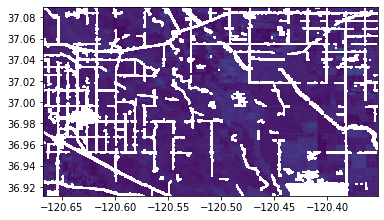

Opened 1 images.
773370 total data points recovered.


In [2]:
#######################################################################
# BEGIN: ESTABLISH REFERENCE DATAFRAME
#######################################################################

DESIS_df = pd.DataFrame()        # Establish a new dataframe

total_count = 0                  # Establish a counter for number of images

#######################################################################
# Look for variable containing reference image directory
# -- Open directory
# -- Open all images in directory
# -- Read each image
# -- Add each pixel of each image to master DataFrame
#######################################################################

from os import listdir            # Import directory library from OS
from os.path import isfile, join  # Import file functions from os

# Establish a list of images from all files in image directory
DESIS_Images = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

#######################################################################
# BEGIN: REFERENCE DATAFRAME POPULATION
#######################################################################

for image in DESIS_Images:                      # For each image in dir,
    dataset = rasterio.open(IMAGE_PATH + image) # Open the image
    show(dataset)
    dataset_meta = dataset.meta                 # Capture metadata
    datalist = []                               # Establish list

    for band in range(1, dataset.count+1):      # Cycle bands
        band_array = dataset.read(band)         # Read band info
        datalist.append(band_array)             # Write band info to DF

    NUM_BANDS = dataset.count                   # Capture num bands

    datalist = np.array(datalist)               # Convert data to NParray

    # Transpose DataFrame info to wide format
    temp_df = pd.DataFrame(datalist.reshape([NUM_BANDS,-1]).T)#.dropna()
    
    # Add single image DataFrame info to master DataFrame
    DESIS_df = pd.concat( [DESIS_df, temp_df], axis=0 )
    
    # Increment number of images
    total_count += 1

#######################################################################
# BEGIN: OUTPUT DIAGNOSTICS
#######################################################################

print("Opened " + str(total_count) + " images.")
print(str(DESIS_df.shape[0]) + " total data points recovered.")

#######################################################################
# BEGIN: OUTPUT DIAGNOSTICS
#######################################################################

#import matplotlib.pyplot as plt
#plt.matshow(DESIS_df.corr())
#plt.show()

#DESIS_df.corr()

#######################################################################
# END: ESTABLISH REFERENCE DATAFRAME
#######################################################################

In [3]:
#######################################################################
# BEGIN: COPY AND MANIPULATE REFERENCE DATA
#######################################################################

desis_df = DESIS_df.copy() # Copy master reference DataFrame


desis_df[LABEL_COL] = np.where(desis_df[LABEL_COL] == 225.0, 1.0, desis_df[LABEL_COL] )
desis_df[LABEL_COL] = np.where(desis_df[LABEL_COL] == 24.0, 1.0, desis_df[LABEL_COL] )
#desis_df[LABEL_COL] = np.where(desis_df[LABEL_COL] == 1.0, 500.0, desis_df[LABEL_COL] )


desis_df[LABEL_COL] = np.where(desis_df[LABEL_COL] == 75.0, 204.0, desis_df[LABEL_COL] )

desis_df[LABEL_COL+1] = desis_df[6] + desis_df[13] + desis_df[20]
desis_df[LABEL_COL+2] = desis_df[27] + desis_df[34] + desis_df[41]
desis_df[LABEL_COL+3] = desis_df[48] + desis_df[55] + desis_df[62]
desis_df[LABEL_COL+4] = desis_df[69] + desis_df[76] + desis_df[83]

#desis_df = desis_df[[6,13,20,27,34,41,48,55,62,69,76,83,LABEL_COL-1,LABEL_COL,LABEL_COL+1,LABEL_COL+2,LABEL_COL+3,LABEL_COL+4]]


# Set all crop labels NOT in list of interested crops to 'Other Crops' (500)
desis_df[LABEL_COL] = np.where(~desis_df[LABEL_COL].isin(SPECIFIC_CROPS), 500, desis_df[LABEL_COL])

#desis_df = desis_df[desis_df[55] >= NDVI_THRESHOLD] # Select only high-confidence

#desis_df = desis_df[desis_df[LABEL_COL-2] >= 3]

desis_df = desis_df[desis_df[LABEL_COL-1] >= CONFIDENCE_LEVEL] # Select only high-confidence
desis_df = desis_df.drop (LABEL_COL-1, axis=1)

#desis_df = desis_df.groupby( LABEL_COL ).apply( lambda x: x.sample( 35000, replace=True ) )

desis_df = desis_df.reset_index(drop=True)

# For copied DataFrame, do not include labels(?)
desis_df_all = desis_df

#######################################################################
# BEGIN: IDENTIFY FEATURES AND LABELS, CREATE TRAIN / TEST SETS
#######################################################################

# Split DF into features and labels
FEATURES = desis_df.loc[:, desis_df.columns != LABEL_COL]

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit( FEATURES )
FEATURES = imp.transform( FEATURES )

LABELS = desis_df.loc[:, desis_df.columns == LABEL_COL]
LABELS = LABELS[LABEL_COL]

# Using features/labels, create test-train split
X_train, X_test, y_train, y_test = train_test_split(
                                                    FEATURES,
                                                    LABELS,
                                                    test_size=0.01,
                                                    random_state=42,
                                                    stratify=desis_df[LABEL_COL]
                                                   )

#######################################################################
# BEGIN: PRINT TRAINING AND NOMINAL DATA DISTRIBUTIONS
#######################################################################


print("\nDISTRIBUTION: ")
print((pd.DataFrame(y_train).value_counts(normalize=True)*100))
#print("\nNORMAL DISTRIBUTION: ")
#print((desis_df_all[LABEL_COL].value_counts(normalize=True)*100))

print( desis_df )

#######################################################################
# END: REFERENCE DATA / LOGGING
#######################################################################


DISTRIBUTION: 
86   
204.0    43.110122
500.0    32.646223
2.0      10.304384
36.0      8.963638
69.0      4.975632
dtype: float64
            0       1       2       3       4       5         6       7   \
0       0.0321  0.0456  0.0306  0.2242  0.1391  0.0804  0.759812  0.0244   
1       0.0297  0.0452  0.0281  0.2435  0.1363  0.0760  0.793078  0.0230   
2       0.0292  0.0451  0.0289  0.2496  0.1384  0.0770  0.792460  0.0242   
3       0.0292  0.0451  0.0289  0.2496  0.1384  0.0770  0.792460  0.0242   
4       0.0284  0.0450  0.0296  0.2513  0.1391  0.0766  0.789249  0.0251   
...        ...     ...     ...     ...     ...     ...       ...     ...   
711118  0.0692  0.0792  0.0905  0.1472  0.2270  0.1874  0.241144  0.1196   
711119  0.0692  0.0805  0.0923  0.1483  0.2300  0.1933  0.239140  0.1182   
711120  0.0694  0.0814  0.0933  0.1497  0.2323  0.1956  0.233182  0.1141   
711121  0.0673  0.0780  0.0886  0.1449  0.2238  0.1887  0.242268  0.1111   
711122  0.0656  0.0743  0.0838  

In [4]:
desis_df[LABEL_COL].value_counts()

204.0    306566
500.0    232155
2.0       73277
36.0      63742
69.0      35383
Name: 86, dtype: int64

In [5]:
#######################################################################
# BEGIN: ESTABLISH AND FIT DATA SCALER
#######################################################################

SCALER_NAME = '4-1-24-Scaler'

try:
    # If scaler exists, open it and fit the current data to it
    scaler = pickle.load(open(SCALER_NAME + ".pickle", "rb"))
    scaler.fit(X_train)
except (OSError, IOError) as e:
    # If scaler does NOT exist, create a new one, fit data, and save
    #pickle.dump(normalizer, open("clf_normalizer.pickle", "wb"))
    scaler = StandardScaler() 
    scaler.fit(X_train)
    pickle.dump(scaler, open(SCALER_NAME + ".pickle", "wb"))

# Establish train / test sets & scale

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#######################################################################
# END: SCALING
#######################################################################

In [ ]:
#######################################################################
# BEGIN: CREATE/LOAD/FIT MODEL
#######################################################################

MODEL_NAME = "4-2-24_model"

try:
    # If model exists, try to load it
    clf = pickle.load( open( MODEL_NAME + ".pickle", "rb" ) )
    
except (OSError, IOError) as e:
    # If model does not exist, establish with following params:

    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
    
    clf = MLPClassifier(
        solver             = 'adam',            # Optimizer to be used.              Options: lbfgs, adam, sgd
        activation         = 'relu',            # Activation function                Options: relu, sigmoid, hyperbolic tan
        alpha              = 0.0001,              # Alpha variable value
        hidden_layer_sizes = ( math.floor( LABEL_COL / 2 ) ),
        learning_rate      = 'constant',        # Learning rate. Fixed value, or adaptive
        max_iter           = 100,               # Max number of epochs to run
        random_state       = 69420,             # Seed for generation of weights
        warm_start         = True,              # Whether or not to use previous initialization as start
        verbose            = True,              # Logging output
        shuffle            = True,              # Whether or not samples are shuffled each epoch
        early_stopping     = True,              # Will stop training early if validation score starts declining
        validation_fraction = 0.1
    )
    
    parameter_space = {
        'hidden_layer_sizes': [ ( LABEL_COL ), ( LABEL_COL*2 ), ( math.floor( LABEL_COL / 2 ) ) ],
        'max_iter': [ 5, 10, 25, 50, 100, 150 ],
        #'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam', 'lbfgs'],
        #'alpha': [0.0001, 0.05, 0.01],
        #'learning_rate': ['constant','adaptive'],
    }
    
    # Fit the model to the data (TAKES TIME)
    cv = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=3)
    
    history =  cv.fit(X_train, y_train)
    
    # Save (pickle) the model
    pickle.dump(clf, open(MODEL_NAME + ".pickle", "wb"))
    pickle.dump(history, open(MODEL_NAME + "_Loss.pickle", "wb"))
    
    #print('Best parameters found:\n', cv.best_params_)
    
#######################################################################
# END: MODEL ESTABLISHMENT & TRAINING
#######################################################################

Iteration 1, loss = 0.56513111
Iteration 1, loss = 0.56488227
Validation score: 0.832829
Validation score: 0.833451
Iteration 1, loss = 0.56431327
Validation score: 0.832364
Iteration 1, loss = 0.41733856
Validation score: 0.870052
Iteration 2, loss = 0.46438864
Iteration 2, loss = 0.46397746
Validation score: 0.842460
Validation score: 0.843166
Iteration 2, loss = 0.46328576
Validation score: 0.841312
Iteration 2, loss = 0.35306605
Validation score: 0.870797
Iteration 3, loss = 0.43670559
Iteration 3, loss = 0.43756067
Validation score: 0.850343
Validation score: 0.850240
Iteration 3, loss = 0.43620337
Validation score: 0.849792
Iteration 3, loss = 0.33872556
Validation score: 0.881429
Iteration 4, loss = 0.41921520
Iteration 4, loss = 0.42023247
Validation score: 0.855034
Validation score: 0.855670
Iteration 4, loss = 0.41886035
Validation score: 0.853500
Iteration 4, loss = 0.33042212
Validation score: 0.881983
Iteration 5, loss = 0.40670188
Iteration 5, loss = 0.40794705
Validation

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation score: 0.860357
Iteration 5, loss = 0.40661202
Validation score: 0.858229


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.32495969
Validation score: 0.885158


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.41698939
Iteration 1, loss = 0.41661095
Validation score: 0.864685
Validation score: 0.865900
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8175     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74033D+00    |proj g|=  3.29592D-01


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8175     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74049D+00    |proj g|=  3.30536D-01


 This problem is unconstrained.


Iteration 2, loss = 0.35260505
Validation score: 0.876574
Iteration 2, loss = 0.35119180
Validation score: 0.875637

At iterate    1    f=  1.00945D+00    |proj g|=  1.73961D-01

At iterate    1    f=  1.00841D+00    |proj g|=  1.73453D-01
Iteration 3, loss = 0.33773999
Validation score: 0.880643
Iteration 3, loss = 0.33723324
Validation score: 0.878662

At iterate    2    f=  8.36517D-01    |proj g|=  1.40760D-01

At iterate    2    f=  8.36947D-01    |proj g|=  1.41696D-01
Iteration 4, loss = 0.32958561
Validation score: 0.881474
Iteration 4, loss = 0.32900728
Validation score: 0.881602

At iterate    3    f=  7.51712D-01    |proj g|=  3.86143D-02

At iterate    3    f=  7.52216D-01    |proj g|=  3.81184D-02
Iteration 5, loss = 0.32393105
Validation score: 0.881283


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.32372596
Validation score: 0.881538


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(



At iterate    4    f=  7.15495D-01    |proj g|=  3.32110D-02

At iterate    4    f=  7.15986D-01    |proj g|=  3.31147D-02
Iteration 1, loss = 0.56513111
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8175     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73949D+00    |proj g|=  3.29613D-01
Validation score: 0.832829


 This problem is unconstrained.



At iterate    5    f=  6.25299D-01    |proj g|=  2.48209D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8175      5      6      1     0     0   2.482D-02   6.253D-01
  F =  0.62529905185891088     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    5    f=  6.25787D-01    |proj g|=  2.47968D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8175      5      6      1     0     0   2.480D-02   6.258D-01
  F =  0.62578686664528194     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 2, loss = 0.46438864
Validation score: 0.842460

At iterate    1    f=  1.01064D+00    |proj g|=  1.74829D-01
Iteration 1, loss = 0.56488227
Validation score: 0.833451
Iteration 3, loss = 0.43756067
Validation score: 0.850343
Iteration 1, loss = 0.56431327
Validation score: 0.832364

At iterate    2    f=  8.37746D-01    |proj g|=  1.42249D-01
Iteration 2, loss = 0.46397746
Validation score: 0.843166
Iteration 4, loss = 0.42023247
Validation score: 0.855670
Iteration 2, loss = 0.46328576
Validation score: 0.841312

At iterate    3    f=  7.52442D-01    |proj g|=  3.92376D-02
Iteration 3, loss = 0.43670559
Validation score: 0.850240
Iteration 5, loss = 0.40794705
Validation score: 0.860357
Iteration 3, loss = 0.43620337
Validation score: 0.849792

At iterate    4    f=  7.16322D-01    |proj g|=  3.31970D-02
Iteration 4, loss = 0.41921520
Validation score: 0.855034
Iteration 6, loss = 0.39882326
Validation score: 0.862509
Iteration 4, loss = 0.41886035
Validation score: 0.85350

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 5, loss = 0.40670188
Validation score: 0.858059
Iteration 7, loss = 0.39134076
Validation score: 0.865108
Iteration 5, loss = 0.40661202
Validation score: 0.858229
Iteration 6, loss = 0.39733549
Validation score: 0.861638
Iteration 8, loss = 0.38504564
Iteration 1, loss = 0.41733856
Validation score: 0.868432
Validation score: 0.870052
Iteration 6, loss = 0.39719978
Validation score: 0.860637
Iteration 7, loss = 0.38982440
Validation score: 0.862682
Iteration 9, loss = 0.37966704
Validation score: 0.869881
Iteration 7, loss = 0.38970201
Iteration 2, loss = 0.35306605
Validation score: 0.861404
Validation score: 0.870797
Iteration 8, loss = 0.38355607
Validation score: 0.868243
Iteration 10, loss = 0.37502843
Validation score: 0.871479


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.38348800
Validation score: 0.865324
Iteration 3, loss = 0.33872556
Validation score: 0.881429
Iteration 9, loss = 0.37819811
Validation score: 0.869117
Iteration 9, loss = 0.37829524
Validation score: 0.866390
Iteration 4, loss = 0.33042212
Validation score: 0.881983
Iteration 1, loss = 0.41698939
Validation score: 0.864685
Iteration 10, loss = 0.37347124
Validation score: 0.867945


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.37360831
Validation score: 0.866518


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.32495969
Validation score: 0.885158
Iteration 2, loss = 0.35260505
Validation score: 0.876574
Iteration 6, loss = 0.32148674
Iteration 1, loss = 0.41661095
Validation score: 0.879064
Validation score: 0.865900
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8175     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74033D+00    |proj g|=  3.29592D-01


 This problem is unconstrained.


Iteration 3, loss = 0.33773999
Validation score: 0.880643
Iteration 7, loss = 0.31812138
Iteration 2, loss = 0.35119180
Validation score: 0.883155
Validation score: 0.875637

At iterate    1    f=  1.00945D+00    |proj g|=  1.73961D-01
Iteration 4, loss = 0.32958561
Validation score: 0.881474
Iteration 8, loss = 0.31577499
Validation score: 0.885691
Iteration 3, loss = 0.33723324
Validation score: 0.878662

At iterate    2    f=  8.36517D-01    |proj g|=  1.40760D-01
Iteration 5, loss = 0.32393105
Validation score: 0.881283
Iteration 9, loss = 0.31343850
Validation score: 0.887523
Iteration 4, loss = 0.32900728
Validation score: 0.881602

At iterate    3    f=  7.51712D-01    |proj g|=  3.86143D-02
Iteration 6, loss = 0.32001658
Validation score: 0.881645
Iteration 10, loss = 0.31140514
Validation score: 0.883560


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.32372596
Validation score: 0.881538

At iterate    4    f=  7.15495D-01    |proj g|=  3.32110D-02
Iteration 7, loss = 0.31659794
Validation score: 0.883712
Iteration 6, loss = 0.31985572
Validation score: 0.880686

At iterate    5    f=  6.25299D-01    |proj g|=  2.48209D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8175     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74049D+00    |proj g|=  3.30536D-01
Iteration 8, loss = 0.31364789


 This problem is unconstrained.


Validation score: 0.884308
Iteration 7, loss = 0.31684260
Validation score: 0.881432

At iterate    6    f=  5.95376D-01    |proj g|=  1.49352D-01
Iteration 9, loss = 0.31277319

At iterate    1    f=  1.00841D+00    |proj g|=  1.73453D-01
Validation score: 0.884457
Iteration 8, loss = 0.31405946
Validation score: 0.883221
Iteration 10, loss = 0.30982608

At iterate    7    f=  5.78553D-01    |proj g|=  6.14481D-02
Validation score: 0.886226

At iterate    2    f=  8.36947D-01    |proj g|=  1.41696D-01


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.31228262
Validation score: 0.884585

At iterate    8    f=  5.67873D-01    |proj g|=  2.54219D-02

At iterate    3    f=  7.52216D-01    |proj g|=  3.81184D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8175     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73949D+00    |proj g|=  3.29613D-01


 This problem is unconstrained.


Iteration 10, loss = 0.30997452
Validation score: 0.883285


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



At iterate    9    f=  5.59089D-01    |proj g|=  2.32305D-02

At iterate    4    f=  7.15986D-01    |proj g|=  3.31147D-02

At iterate    1    f=  1.01064D+00    |proj g|=  1.74829D-01
Iteration 1, loss = 0.56513111
Validation score: 0.832829

At iterate   10    f=  5.47466D-01    |proj g|=  4.13650D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8175     10     11      1     0     0   4.136D-02   5.475D-01
  F =  0.54746552088735179     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    5    f=  6.25787D-01    |proj g|=  2.47968D-02

At iterate    2    f=  8.37746D-01    |proj g|=  1.42249D-01
Iteration 2, loss = 0.46438864
Validation score: 0.842460

At iterate    6    f=  5.90091D-01    |proj g|=  8.34310D-02
Iteration 1, loss = 0.56488227
Validation score: 0.833451

At iterate    3    f=  7.52442D-01    |proj g|=  3.92376D-02
Iteration 3, loss = 0.43756067
Validation score: 0.850343
Iteration 2, loss = 0.46397746
Validation score: 0.843166

At iterate    4    f=  7.16322D-01    |proj g|=  3.31970D-02
Iteration 4, loss = 0.42023247
Validation score: 0.855670
Iteration 3, loss = 0.43670559
Validation score: 0.850240

At iterate    7    f=  5.73655D-01    |proj g|=  2.49510D-02
Iteration 5, loss = 0.40794705
Validation score: 0.860357

At iterate    5    f=  6.26006D-01    |proj g|=  2.50585D-02
Iteration 4, loss = 0.41921520
Validation score: 0.855034

At iterate    8    f=  5.66262D-01    |proj g|=  2.61932D-02
Iteration 6, loss = 0.39882326
Validatio

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate    7    f=  5.83677D-01    |proj g|=  3.78984D-02
Iteration 7, loss = 0.38982440
Validation score: 0.862682
Iteration 9, loss = 0.37966704
Validation score: 0.869881
Iteration 1, loss = 0.56431327
Validation score: 0.832364

At iterate    8    f=  5.69220D-01    |proj g|=  1.54571D-02
Iteration 8, loss = 0.38355607
Validation score: 0.868243
Iteration 10, loss = 0.37502843
Validation score: 0.871479
Iteration 2, loss = 0.46328576
Validation score: 0.841312
Iteration 9, loss = 0.37819811
Validation score: 0.869117

At iterate    9    f=  5.49481D-01    |proj g|=  1.07130D-02
Iteration 11, loss = 0.37099677
Validation score: 0.871373
Iteration 3, loss = 0.43620337
Validation score: 0.849792
Iteration 10, loss = 0.37347124
Validation score: 0.867945

At iterate   10    f=  5.23760D-01    |proj g|=  1.35204D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip 

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iteration 12, loss = 0.36729623
Validation score: 0.871713
Iteration 4, loss = 0.41886035
Validation score: 0.853500
Iteration 11, loss = 0.36942740
Validation score: 0.870417
Iteration 13, loss = 0.36409021
Validation score: 0.873482
Iteration 1, loss = 0.41733856
Validation score: 0.870052
Iteration 5, loss = 0.40661202
Validation score: 0.858229
Iteration 12, loss = 0.36577927
Validation score: 0.870757
Iteration 14, loss = 0.36119009
Validation score: 0.872630
Iteration 2, loss = 0.35306605
Validation score: 0.870797
Iteration 6, loss = 0.39719978
Validation score: 0.860637
Iteration 13, loss = 0.36259138
Validation score: 0.871887
Iteration 15, loss = 0.35848496
Validation score: 0.873503
Iteration 3, loss = 0.33872556
Validation score: 0.881429
Iteration 7, loss = 0.38970201
Validation score: 0.861404
Iteration 14, loss = 0.35949140
Validation score: 0.873549
Iteration 16, loss = 0.35600084
Validation score: 0.874739



PREDICTION DISTRIBUTION: 
204.0    44.388068
500.0    33.084164
2.0      11.131800
36.0      7.253191
69.0      4.142778
dtype: float64

ACTUAL DISTRIBUTION: 
204.0    40.560146
500.0    35.262552
2.0      11.288516
36.0      8.254135
69.0      4.634651
Name: 86, dtype: float64

Accuracy: 73.68995435561246%


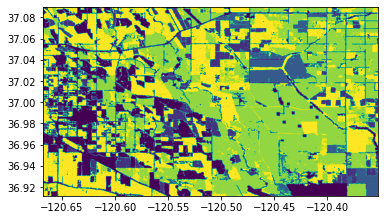

<AxesSubplot:>

In [103]:
#######################################################################
# BEGIN: MODEL VERIFICATION & PREDICTION
# -- BEGIN: OPEN PREDICTION IMAGE AND PARSE DATA
#######################################################################

import matplotlib.colors as colors

IMAGE_PATH = './Test_Max/'

desis_image = '2022i.tif'
dataset = rasterio.open(IMAGE_PATH + desis_image, crop=False)
dataset_meta = dataset.meta
datalist = []

for band in range(1, dataset.count+1):
    band_array = dataset.read(band)
    datalist.append(band_array)

NUM_BANDS = dataset.count

datalist = np.array(datalist)

desis_df_all = pd.DataFrame(datalist.reshape([NUM_BANDS,-1]).T)#.dropna()


desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 225.0, 1, desis_df_all[LABEL_COL] )
desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 24.0, 1, desis_df_all[LABEL_COL] )
#desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 1.0, 500.0, desis_df_all[LABEL_COL] )

desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 75.0, 204.0, desis_df_all[LABEL_COL] )

desis_df_all[LABEL_COL+1] = desis_df_all[6] + desis_df_all[13] + desis_df_all[20]
desis_df_all[LABEL_COL+2] = desis_df_all[27] + desis_df_all[34] + desis_df_all[41]
desis_df_all[LABEL_COL+3] = desis_df_all[48] + desis_df_all[55] + desis_df_all[62]
desis_df_all[LABEL_COL+4] = desis_df_all[69] + desis_df_all[76] + desis_df_all[83]

#desis_df_all = desis_df_all[[6,13,20,27,34,41,48,55,62,69,76,83,LABEL_COL-1,LABEL_COL,LABEL_COL+1,LABEL_COL+2,LABEL_COL+3,LABEL_COL+4]]


desis_df_all[LABEL_COL] = np.where(~desis_df_all[LABEL_COL].isin(SPECIFIC_CROPS), 500, desis_df_all[LABEL_COL])

desis_df_all = desis_df_all.drop(LABEL_COL-1, axis=1)

unmod_df = desis_df_all.copy()

# -- END: OPEN PREDICTION IMAGE AND PARSE DATA
# -- BEGIN: FEATURE/LABEL SPLIT AND PREDICT IMAGE

#desis_df_all[0:59] = desis_df_all[0:59] / 10000
imp.fit( (np.array(desis_df_all.loc[:, desis_df_all.columns != LABEL_COL])) )
train_all = imp.transform( (np.array(desis_df_all.loc[:, desis_df_all.columns != LABEL_COL])) )

#train_all = (np.array(desis_df_all.loc[:, desis_df_all.columns != LABEL_COL])) #scaler.transform
labels_all = np.array(desis_df_all.loc[:, desis_df_all.columns == LABEL_COL])#.dropna())

#train_all = imp.transform( train_all )
train_all = scaler.transform( train_all )

predictions = clf.predict(train_all)

#unmod_df[LABEL_COL] = predictions

test_band = dataset.read(1)
row_i = 0
col_i = 0
test = 0

for row in test_band:
    col_i = 0
    for col in row:
        if(col > 0):
            test_band[row_i][col_i] = predictions[test]
        test+=1
        col_i += 1
    row_i += 1

dataset_meta.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw')

with rasterio.open(MODEL_NAME+'_CLASSIFIED_IMAGE.tif', 'w', **dataset_meta) as dst:
    dst.write(test_band, 1)

# Get final predicted image, open and read for accuracy & display
final_image = rasterio.open(MODEL_NAME+'_CLASSIFIED_IMAGE.tif')

# END -- FEATURE/LABEL SPLIT AND PREDICT IMAGE
# BEGIN -- LOG DATA DISTRIBUTIONS / ACCURACY / FINAL PREDICTION

print("\nPREDICTION DISTRIBUTION: ")
print((pd.DataFrame(predictions).value_counts(normalize=True)*100))
print("\nACTUAL DISTRIBUTION: ")
print((desis_df_all[LABEL_COL].value_counts(normalize=True)*100))
print("\nAccuracy: " + str( accuracy_score( predictions, labels_all ) * 100) + "%")
show(final_image)

# END -- LOG DATA DISTRIBUTIONS / ACCURACY / FINAL PREDICTION

#######################################################################
# END: PREDICT IMAGE AND LOG ACCURACY
#######################################################################

In [104]:
#######################################################################
# BEGIN: CREATE PREDICTION IMAGE ERROR MATRIX
#######################################################################
SPECIFIC_CROPS = [ 2.0, 36.0, 69.0, 204.0, 500.0 ]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#SPECIFIC_CROPS = [ 204.0, 2.0, 36.0, 54.0, 69.0, 1.0, 500.0, 75.0 ]

#predictions = unmod_df[LABEL_COL]
#labels_all = desis_df_all[LABEL_COL]

desis_confusion_matrix = confusion_matrix(labels_all, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=desis_confusion_matrix,
                              display_labels=SPECIFIC_CROPS )

#confusion_df = pd.DataFrame(desis_confusion_matrix, columns=clf.classes_, index=clf.classes_)
confusion_df = pd.DataFrame(desis_confusion_matrix, columns=SPECIFIC_CROPS, index=SPECIFIC_CROPS )

import warnings
warnings.filterwarnings("ignore")

#Total sum per column:
confusion_df.loc['Total',:] = confusion_df.sum(axis=0)

#Total sum per row:
confusion_df.loc[:,'Total'] = confusion_df.sum(axis=1)

# NUM CROPS INCLUDING OTHER
num_crops = len( SPECIFIC_CROPS ) +1

confusion_df['User Acc'] = pd.Series(np.random.randn(num_crops), index=confusion_df.index)



for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0, 
    confusion_df['User Acc'][index] = str(round( (confusion_df[index][index] / confusion_df['Total'][index] * 100), 2) ) + "%"

confusion_df['User Acc']['Total'] = None

#Total sum per row: 
confusion_df.loc['Producer Acc',:] = confusion_df.sum(axis=1)
for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0,
    confusion_df[index]['Producer Acc'] = str( round( (confusion_df[index][index] / confusion_df[index]['Total'] * 100), 2 ) ) + "%"
    
confusion_df['Total']['Producer Acc'] = None

holder = 0
for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0, 69.0,
    holder += confusion_df[index][index]
    
confusion_df['User Acc']['Producer Acc'] = str( round ( ( ( holder / confusion_df['Total']['Total'] ) * 100 ), 2) ) + "%"

# BEGIN -- RENAME MATRIX VALS TO CROP NAME STRINGS
confusion_df = confusion_df.rename(
    columns={
        75.0:"Almonds",
        204.0:"Pistachios", #"Tree Crops",
        2.0:"Cotton",
        36.0:"Alfalfa",
        225.0:"Dbl Crop WinWht/Corn",
        54.0:"Tomatoes", 
        69.0:"Grapes", 
        24.0:"Winter Wheat",
        61.0:"Fallow",
        1.0:"Corn",
        500.0:"Other", 
        "Total":"Total", 
        "User Acc":"User Accuracy"
    },
    index={
        75.0:"Almonds",
        204.0:"Pistachios", #"Tree Crops"
        2.0:"Cotton",
        36.0:"Alfalfa",
        225.0:"Dbl Crop WinWht/Corn",
        54.0:"Tomatoes", 
        69.0:"Grapes", 
        24.0:"Winter Wheat",
        61.0:"Fallow",
        1.0:"Corn",
        500.0:"Other", 
        "Total":"Total", 
        "Producer Acc":"Producer Accuracy"
    }
)

# END -- RENAME MATRIX VALS TO CROP NAME STRINGS

# Save final error matrix to drive
confusion_df.to_csv(MODEL_NAME+"_accuracy_scores.csv")

#######################################################################
# END: PREDICTION IMAGE ERROR MATRIX
#######################################################################

In [105]:
unmod_df[LABEL_COL] = predictions

In [81]:
SECONDARY_CROPS = [ 1.0, 24.0, 225.0 ]

grain_df = DESIS_df.copy()

#GOOD_CROPS = [2.0, 24.0]

#grain_df = grain_df[grain_df[LABEL_COL] != 2.0]
#grain_df = grain_df[grain_df[LABEL_COL] != 24.0]


#grain_df[LABEL_COL] = np.where( ~grain_df[LABEL_COL].isin( SECONDARY_CROPS ), 500.0, grain_df[LABEL_COL] )
grain_df = grain_df.loc[ grain_df[ LABEL_COL ].isin( SECONDARY_CROPS ) ]

grain_df[LABEL_COL+1] = grain_df[6] + grain_df[13] + grain_df[20]
grain_df[LABEL_COL+2] = grain_df[27] + grain_df[34] + grain_df[41]
grain_df[LABEL_COL+3] = grain_df[48] + grain_df[55] + grain_df[62]
grain_df[LABEL_COL+4] = grain_df[69] + grain_df[76] + grain_df[83]

grain_df = grain_df.drop (LABEL_COL-1, axis=1)
grain_df = grain_df.reset_index(drop=True)
grain_train = scaler.transform( imp.transform( grain_df.loc[:, grain_df.columns != LABEL_COL] ) )
grain_label = grain_df.loc[:, grain_df.columns == LABEL_COL][LABEL_COL]

grain_clf = MLPClassifier(
        solver             = 'adam',            # Optimizer to be used.              Options: lbfgs, adam, sgd
        activation         = 'relu',            # Activation function                Options: relu, sigmoid, hyperbolic tan
        alpha              = 0.0001,              # Alpha variable value
        hidden_layer_sizes = ( math.floor( LABEL_COL / 2 ) ),
        learning_rate      = 'constant',        # Learning rate. Fixed value, or adaptive
        max_iter           = 100,               # Max number of epochs to run
        random_state       = 69420,             # Seed for generation of weights
        warm_start         = True,              # Whether or not to use previous initialization as start
        verbose            = False,              # Logging output
        shuffle            = True,              # Whether or not samples are shuffled each epoch
        early_stopping     = True,              # Will stop training early if validation score starts declining
        validation_fraction = 0.1
    )

grain_history = grain_clf.fit(grain_train, grain_label)



In [82]:
desis_df_all[LABEL_COL] = predictions

new = desis_df_all.copy()
le_grains = new.loc[new[LABEL_COL].isin( SECONDARY_CROPS ) ]

grain_train = scaler.transform( imp.transform( le_grains.loc[:, le_grains.columns != LABEL_COL] ) )
grain_label = grain_df.loc[:, le_grains.columns == LABEL_COL]

grains_predict = grain_clf.predict( grain_train )

desis_df_all[86][desis_df_all[86].isin( SECONDARY_CROPS )] = grains_predict

In [83]:
predictions = desis_df_all[LABEL_COL]
desis_df_all[LABEL_COL].value_counts()

204.0    309918
500.0    161533
2.0       99607
36.0      70774
225.0     45293
24.0      41042
69.0      32290
1.0       12913
Name: 86, dtype: int64

In [106]:
SECONDARY_CROPS = [ 75.0, 204.0 ]

grain_df = DESIS_df.copy()

#GOOD_CROPS = [2.0, 24.0]

#grain_df = grain_df[grain_df[LABEL_COL] != 2.0]
#grain_df = grain_df[grain_df[LABEL_COL] != 24.0]


#grain_df[LABEL_COL] = np.where( ~grain_df[LABEL_COL].isin( SECONDARY_CROPS ), 500.0, grain_df[LABEL_COL] )
grain_df = grain_df.loc[ grain_df[ LABEL_COL ].isin( SECONDARY_CROPS ) ]
grain_df = grain_df.loc[ grain_df[20] >= NDVI_THRESHOLD] # Select only high-confidence 55

grain_df[LABEL_COL+1] = grain_df[6] + grain_df[13] + grain_df[20]
grain_df[LABEL_COL+2] = grain_df[27] + grain_df[34] + grain_df[41]
grain_df[LABEL_COL+3] = grain_df[48] + grain_df[55] + grain_df[62]
grain_df[LABEL_COL+4] = grain_df[69] + grain_df[76] + grain_df[83]

grain_df = grain_df.drop (LABEL_COL-1, axis=1)
grain_df = grain_df.reset_index(drop=True)
grain_train = scaler.transform( imp.transform( grain_df.loc[:, grain_df.columns != LABEL_COL] ) )
grain_label = grain_df.loc[:, grain_df.columns == LABEL_COL][LABEL_COL]

grain_clf = MLPClassifier(
        solver             = 'adam',            # Optimizer to be used.              Options: lbfgs, adam, sgd
        activation         = 'relu',            # Activation function                Options: relu, sigmoid, hyperbolic tan
        alpha              = 0.0001,              # Alpha variable value
        hidden_layer_sizes = ( math.floor( LABEL_COL / 2 ) ),
        learning_rate      = 'constant',        # Learning rate. Fixed value, or adaptive
        max_iter           = 100,               # Max number of epochs to run
        random_state       = 69420,             # Seed for generation of weights
        warm_start         = True,              # Whether or not to use previous initialization as start
        verbose            = False,              # Logging output
        shuffle            = True,              # Whether or not samples are shuffled each epoch
        early_stopping     = True,              # Will stop training early if validation score starts declining
        validation_fraction = 0.1
    )

grain_history = grain_clf.fit(grain_train, grain_label)



In [107]:
desis_df_all[LABEL_COL] = predictions

new = desis_df_all.copy()
le_grains = new.loc[new[LABEL_COL].isin( SECONDARY_CROPS ) ]
le_grains = le_grains.loc[ le_grains[20] >= NDVI_THRESHOLD] # Select only high-confidence


grain_train = scaler.transform( imp.transform( le_grains.loc[:, le_grains.columns != LABEL_COL] ) )
grain_label = grain_df.loc[:, le_grains.columns == LABEL_COL]

grains_predict = grain_clf.predict( grain_train )

desis_df_all[86].loc[ ( desis_df_all[86].isin( SECONDARY_CROPS ) ) & ( desis_df_all[20] >= NDVI_THRESHOLD ) ] = grains_predict

In [108]:
FINAL_PREDICTIONS = desis_df_all[LABEL_COL]#.copy()

In [109]:
desis_df_all[LABEL_COL].value_counts()

500.0    255863
75.0     227021
204.0    116263
2.0       86090
36.0      56094
69.0      32039
Name: 86, dtype: int64

In [110]:
#######################################################################
# BEGIN: CREATE PREDICTION IMAGE ERROR MATRIX
#######################################################################

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#SPECIFIC_CROPS = [ 204.0, 2.0, 36.0, 54.0, 69.0, 1.0, 500.0, 75.0 ]


#######################################################################
# BEGIN: MODEL VERIFICATION & PREDICTION
# -- BEGIN: OPEN PREDICTION IMAGE AND PARSE DATA
#######################################################################
SPECIFIC_CROPS = [ 2.0, 36.0, 69.0, 75.0, 204.0, 500.0 ]

import matplotlib.colors as colors

IMAGE_PATH = './Test_Max/'

desis_image = '2022i.tif'
dataset = rasterio.open(IMAGE_PATH + desis_image, crop=False)
dataset_meta = dataset.meta
datalist = []

for band in range(1, dataset.count+1):
    band_array = dataset.read(band)
    datalist.append(band_array)

NUM_BANDS = dataset.count

datalist = np.array(datalist)

desis_df_all = pd.DataFrame(datalist.reshape([NUM_BANDS,-1]).T)#.dropna()
desis_df_all[LABEL_COL] = np.where(~desis_df_all[LABEL_COL].isin(SPECIFIC_CROPS), 500, desis_df_all[LABEL_COL])
#desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 75.0, 204.0, desis_df_all[LABEL_COL] )




labels_all = desis_df_all[LABEL_COL]
predictions = FINAL_PREDICTIONS

desis_confusion_matrix = confusion_matrix(predictions, labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=desis_confusion_matrix,
                              display_labels=SPECIFIC_CROPS )

#confusion_df = pd.DataFrame(desis_confusion_matrix, columns=clf.classes_, index=clf.classes_)
confusion_df = pd.DataFrame(desis_confusion_matrix, columns=SPECIFIC_CROPS, index=SPECIFIC_CROPS )

#Total sum per column:
confusion_df.loc['Total',:] = confusion_df.sum(axis=0)

#Total sum per row:
confusion_df.loc[:,'Total'] = confusion_df.sum(axis=1)

# NUM CROPS INCLUDING OTHER
#SPECIFIC_CROPS = [ 1.0, 2.0, 36.0, 69.0, 204.0, 500.0 ]
num_crops = len( SPECIFIC_CROPS ) +1

confusion_df['User Acc'] = pd.Series(np.random.randn(num_crops), index=confusion_df.index)



for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0, 
    confusion_df['User Acc'][index] = str(round( (confusion_df[index][index] / confusion_df['Total'][index] * 100), 2) ) + "%"

confusion_df['User Acc']['Total'] = None

#Total sum per row: 
confusion_df.loc['Producer Acc',:] = confusion_df.sum(axis=1)
for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0,
    confusion_df[index]['Producer Acc'] = str( round( (confusion_df[index][index] / confusion_df[index]['Total'] * 100), 2 ) ) + "%"
    
confusion_df['Total']['Producer Acc'] = None

holder = 0
for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0, 69.0,
    holder += confusion_df[index][index]
    
confusion_df['User Acc']['Producer Acc'] = str( round ( ( ( holder / confusion_df['Total']['Total'] ) * 100 ), 2) ) + "%"

# BEGIN -- RENAME MATRIX VALS TO CROP NAME STRINGS
confusion_df = confusion_df.rename(
    columns={
        75.0:"Almonds",
        204.0:"Pistachios",
        2.0:"Cotton",
        36.0:"Alfalfa",
        225.0:"Dbl Crop WinWht/Corn",
        54.0:"Tomatoes", 
        69.0:"Grapes", 
        24.0:"Winter Wheat",
        61.0:"Fallow",
        1.0:"Corn", #"Corn",
        500.0:"Other", 
        "Total":"Total", 
        "User Acc":"User Accuracy"
    },
    index={
        75.0:"Almonds",
        204.0:"Pistachios",
        2.0:"Cotton",
        36.0:"Alfalfa",
        225.0:"Dbl Crop WinWht/Corn",
        54.0:"Tomatoes", 
        69.0:"Grapes", 
        24.0:"Winter Wheat",
        61.0:"Fallow",
        1.0:"Corn",
        500.0:"Other", 
        "Total":"Total", 
        "Producer Acc":"Producer Accuracy"
    }
)

# END -- RENAME MATRIX VALS TO CROP NAME STRINGS

# Save final error matrix to drive
confusion_df.to_csv(MODEL_NAME+"_accuracy_scores_FINAL.csv")

#######################################################################
# END: PREDICTION IMAGE ERROR MATRIX
#######################################################################

In [111]:
labels_all.value_counts()

500.0    272710
75.0     231329
2.0       87302
204.0     82351
36.0      63835
69.0      35843
Name: 86, dtype: int64

In [112]:
FINAL_PREDICTIONS.value_counts()

500.0    255863
75.0     227021
204.0    116263
2.0       86090
36.0      56094
69.0      32039
Name: 86, dtype: int64


PREDICTION DISTRIBUTION: 
86   
75.0     37.138110
500.0    20.886898
2.0      12.879605
36.0      9.151376
225.0     5.856576
24.0      5.306904
69.0      4.175233
204.0     2.935594
1.0       1.669705
dtype: float64

ACTUAL DISTRIBUTION: 
204.0    40.560146
500.0    25.252208
2.0      11.288516
1.0      10.010344
36.0      8.254135
69.0      4.634651
Name: 86, dtype: float64

Accuracy: 33.61340626091005%


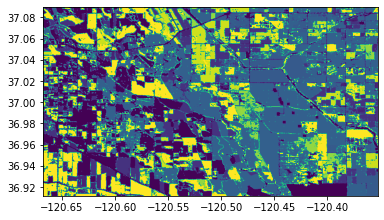

<AxesSubplot:>

In [94]:
#######################################################################
# BEGIN: MODEL VERIFICATION & PREDICTION
# -- BEGIN: OPEN PREDICTION IMAGE AND PARSE DATA
#######################################################################

import matplotlib.colors as colors

IMAGE_PATH = './Test_Max/'

desis_image = '2022i.tif'
dataset = rasterio.open(IMAGE_PATH + desis_image, crop=False)
dataset_meta = dataset.meta
datalist = []

for band in range(1, dataset.count+1):
    band_array = dataset.read(band)
    datalist.append(band_array)

NUM_BANDS = dataset.count

datalist = np.array(datalist)

desis_df_all = pd.DataFrame(datalist.reshape([NUM_BANDS,-1]).T)#.dropna()


desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 225.0, 1, desis_df_all[LABEL_COL] )
desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 24.0, 1, desis_df_all[LABEL_COL] )
#desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 1.0, 500.0, desis_df_all[LABEL_COL] )

desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 75.0, 204.0, desis_df_all[LABEL_COL] )

desis_df_all[LABEL_COL+1] = desis_df_all[6] + desis_df_all[13] + desis_df_all[20]
desis_df_all[LABEL_COL+2] = desis_df_all[27] + desis_df_all[34] + desis_df_all[41]
desis_df_all[LABEL_COL+3] = desis_df_all[48] + desis_df_all[55] + desis_df_all[62]
desis_df_all[LABEL_COL+4] = desis_df_all[69] + desis_df_all[76] + desis_df_all[83]

#desis_df_all = desis_df_all[[6,13,20,27,34,41,48,55,62,69,76,83,LABEL_COL-1,LABEL_COL,LABEL_COL+1,LABEL_COL+2,LABEL_COL+3,LABEL_COL+4]]


desis_df_all[LABEL_COL] = np.where(~desis_df_all[LABEL_COL].isin(SPECIFIC_CROPS), 500, desis_df_all[LABEL_COL])

desis_df_all = desis_df_all.drop(LABEL_COL-1, axis=1)

unmod_df = desis_df_all.copy()

# -- END: OPEN PREDICTION IMAGE AND PARSE DATA
# -- BEGIN: FEATURE/LABEL SPLIT AND PREDICT IMAGE

#desis_df_all[0:59] = desis_df_all[0:59] / 10000
imp.fit( (np.array(desis_df_all.loc[:, desis_df_all.columns != LABEL_COL])) )
train_all = imp.transform( (np.array(desis_df_all.loc[:, desis_df_all.columns != LABEL_COL])) )

#train_all = (np.array(desis_df_all.loc[:, desis_df_all.columns != LABEL_COL])) #scaler.transform
labels_all = np.array(desis_df_all.loc[:, desis_df_all.columns == LABEL_COL])#.dropna())

#train_all = imp.transform( train_all )
train_all = scaler.transform( train_all )

predictions = FINAL_PREDICTIONS#clf.predict(train_all)

#unmod_df[LABEL_COL] = predictions

test_band = dataset.read(1)
row_i = 0
col_i = 0
test = 0

for row in test_band:
    col_i = 0
    for col in row:
        if(col > 0):
            test_band[row_i][col_i] = predictions[test]
        test+=1
        col_i += 1
    row_i += 1

dataset_meta.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw')

with rasterio.open(MODEL_NAME+'_CLASSIFIED_IMAGE.tif', 'w', **dataset_meta) as dst:
    dst.write(test_band, 1)

# Get final predicted image, open and read for accuracy & display
final_image = rasterio.open(MODEL_NAME+'_CLASSIFIED_IMAGE.tif')

# END -- FEATURE/LABEL SPLIT AND PREDICT IMAGE
# BEGIN -- LOG DATA DISTRIBUTIONS / ACCURACY / FINAL PREDICTION

print("\nPREDICTION DISTRIBUTION: ")
print((pd.DataFrame(predictions).value_counts(normalize=True)*100))
print("\nACTUAL DISTRIBUTION: ")
print((desis_df_all[LABEL_COL].value_counts(normalize=True)*100))
print("\nAccuracy: " + str( accuracy_score( predictions, labels_all ) * 100) + "%")
show(final_image)

# END -- LOG DATA DISTRIBUTIONS / ACCURACY / FINAL PREDICTION

#######################################################################
# END: PREDICT IMAGE AND LOG ACCURACY
#######################################################################

In [95]:
FINAL_PREDICTIONS.value_counts()

75.0     287215
500.0    161533
2.0       99607
36.0      70774
225.0     45293
24.0      41042
69.0      32290
204.0     22703
1.0       12913
Name: 86, dtype: int64

In [141]:
grain_final_thing = pd.DataFrame(DESIS_df[LABEL_COL])
grain_final_thing[1] = FINAL_PREDICTIONS

grain_final_thing = grain_final_thing.loc[grain_final_thing[1].isin( SECONDARY_CROPS ) ]

grain_final_thing[LABEL_COL] = np.where(grain_final_thing[LABEL_COL] == 75.0, 204.0, grain_final_thing[LABEL_COL] )

# Set all crop labels NOT in list of interested crops to 'Other Crops' (500)
SPECIFIC_CROPS = [ 1.0, 24.0, 2.0, 36.0, 69.0, 75.0, 204.0, 225.0, 500.0 ]

grain_final_thing[LABEL_COL] = np.where(~grain_final_thing[LABEL_COL].isin(SPECIFIC_CROPS), 500, grain_final_thing[LABEL_COL])

grain_final_thing

,86,1
19,24.0,1.0
20,24.0,1.0
21,24.0,1.0
22,24.0,1.0
23,24.0,1.0
...,...,...
772948,500.0,1.0
772949,500.0,1.0
772950,500.0,1.0
772951,500.0,1.0


In [142]:
#######################################################################
# BEGIN: CREATE PREDICTION IMAGE ERROR MATRIX
#######################################################################

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#SPECIFIC_CROPS = [ 204.0, 2.0, 36.0, 54.0, 69.0, 1.0, 500.0, 75.0 ]


#######################################################################
# BEGIN: MODEL VERIFICATION & PREDICTION
# -- BEGIN: OPEN PREDICTION IMAGE AND PARSE DATA
#######################################################################
SPECIFIC_CROPS = [ 1.0, 24.0, 2.0, 36.0, 69.0, 204.0, 225.0, 500.0 ]

import matplotlib.colors as colors

IMAGE_PATH = './Test_Max/'

desis_image = '2022i.tif'
dataset = rasterio.open(IMAGE_PATH + desis_image, crop=False)
dataset_meta = dataset.meta
datalist = []

for band in range(1, dataset.count+1):
    band_array = dataset.read(band)
    datalist.append(band_array)

NUM_BANDS = dataset.count

datalist = np.array(datalist)

desis_df_all = pd.DataFrame(datalist.reshape([NUM_BANDS,-1]).T)#.dropna()
desis_df_all[LABEL_COL] = np.where(~desis_df_all[LABEL_COL].isin(SPECIFIC_CROPS), 500, desis_df_all[LABEL_COL])
desis_df_all[LABEL_COL] = np.where(desis_df_all[LABEL_COL] == 75.0, 204.0, desis_df_all[LABEL_COL] )




labels_all = grain_final_thing[LABEL_COL]
predictions = grain_final_thing[1]

desis_confusion_matrix = confusion_matrix(predictions, labels_all)
disp = ConfusionMatrixDisplay(confusion_matrix=desis_confusion_matrix,
                              display_labels=SPECIFIC_CROPS )

#confusion_df = pd.DataFrame(desis_confusion_matrix, columns=clf.classes_, index=clf.classes_)
confusion_df = pd.DataFrame(desis_confusion_matrix, columns=SECONDARY_CROPS, index=SPECIFIC_CROPS )

#Total sum per column:
confusion_df.loc['Total',:] = confusion_df.sum(axis=0)

#Total sum per row:
confusion_df.loc[:,'Total'] = confusion_df.sum(axis=1)

# NUM CROPS INCLUDING OTHER
#SPECIFIC_CROPS = [ 1.0, 2.0, 36.0, 69.0, 204.0, 500.0 ]
num_crops = len( SPECIFIC_CROPS ) +1

confusion_df['User Acc'] = pd.Series(np.random.randn(num_crops), index=confusion_df.index)



for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0, 
    confusion_df['User Acc'][index] = str(round( (confusion_df[index][index] / confusion_df['Total'][index] * 100), 2) ) + "%"

confusion_df['User Acc']['Total'] = None

#Total sum per row: 
confusion_df.loc['Producer Acc',:] = confusion_df.sum(axis=1)
for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0,
    confusion_df[index]['Producer Acc'] = str( round( (confusion_df[index][index] / confusion_df[index]['Total'] * 100), 2 ) ) + "%"
    
confusion_df['Total']['Producer Acc'] = None

holder = 0
for index in SPECIFIC_CROPS: #1.0, 2.0, 3.0, 54.0, 69.0,
    holder += confusion_df[index][index]
    
confusion_df['User Acc']['Producer Acc'] = str( round ( ( ( holder / confusion_df['Total']['Total'] ) * 100 ), 2) ) + "%"

# BEGIN -- RENAME MATRIX VALS TO CROP NAME STRINGS
confusion_df = confusion_df.rename(
    columns={
        75.0:"Almonds",
        204.0:"Tree Crops",
        2.0:"Cotton",
        36.0:"Alfalfa",
        225.0:"Dbl Crop WinWht/Corn",
        54.0:"Tomatoes", 
        69.0:"Grapes", 
        24.0:"Winter Wheat",
        61.0:"Fallow",
        1.0:"Corn", #"Corn",
        500.0:"Other", 
        "Total":"Total", 
        "User Acc":"User Accuracy"
    },
    index={
        75.0:"Almonds",
        204.0:"Tree Crops",
        2.0:"Cotton",
        36.0:"Alfalfa",
        225.0:"Dbl Crop WinWht/Corn",
        54.0:"Tomatoes", 
        69.0:"Grapes", 
        24.0:"Winter Wheat",
        61.0:"Fallow",
        1.0:"Corn",
        500.0:"Other", 
        "Total":"Total", 
        "Producer Acc":"Producer Accuracy"
    }
)

# END -- RENAME MATRIX VALS TO CROP NAME STRINGS

# Save final error matrix to drive
confusion_df.to_csv(MODEL_NAME+"_accuracy_scores_ROUND2.csv")

#######################################################################
# END: PREDICTION IMAGE ERROR MATRIX
#######################################################################

ValueError: Shape of passed values is (8, 8), indices imply (8, 3)